In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import os

from ignite.metrics import Precision, Recall, ConfusionMatrix, IoU, Accuracy
import seaborn as sns
import numpy as np

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


In [19]:
DATA_DIR = '/kaggle/input/crack-non-crackv3/crack'  # The folder name from your image

# 1. Setup a temporary dataset just for calculation
calc_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

calc_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, '/kaggle/input/crack-non-crackv3/crack/train'), transform=calc_transform)
calc_dataloader = DataLoader(calc_dataset, batch_size=1000, shuffle=False, num_workers=4)

def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    print("Calculating Mean and Std (this may take a moment)...")
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    
    return mean, std

# Run the function
my_mean, my_std = get_mean_std(calc_dataloader)

# Convert to simple python lists for usage below
norm_mean = my_mean.tolist()
norm_std = my_std.tolist()

Calculating Mean and Std (this may take a moment)...


In [20]:
print(f"Calculated Mean: {norm_mean}")
print(f"Calculated Std:  {norm_std}")

Calculated Mean: [0.5246369242668152, 0.5462915301322937, 0.5596950054168701]
Calculated Std:  [0.11787998676300049, 0.11234196275472641, 0.10545744746923447]


In [44]:
# 1. Configuration
BATCH_SIZE = 128
IMG_HEIGHT = 224 # Resize target
IMG_WIDTH = 224  # Resize target

# 2. Define Transforms (Augmentation + Resize)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        # --- Data Augmentation starts here ---
        transforms.RandomHorizontalFlip(p=0.7),      # 50% chance to flip
        transforms.RandomRotation(degrees=15),       # Rotate +/- 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2), # Adjust lighting
        # --- Data Augmentation ends here ---
        transforms.ToTensor(),
        #transforms.Lambda(lambda x: x.half()),
        transforms.Normalize(mean = norm_mean, std = norm_std) # Standard Normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomHorizontalFlip(p=0.5),      # 50% chance to flip
        transforms.RandomRotation(degrees=15),       # Rotate +/- 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2), # Adjust lighting
        transforms.ToTensor(),
        #transforms.Lambda(lambda x: x.half()),
        transforms.Normalize(mean = norm_mean, std = norm_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        #transforms.Lambda(lambda x: x.half()),
        transforms.Normalize(mean = norm_mean, std = norm_std)
    ]),
    'test_off': transforms.Compose([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.ToTensor(),
        #transforms.Lambda(lambda x: x.half()),
        transforms.Normalize(mean = norm_mean, std = norm_std)
    ])
}

# 3. Load Datasets using ImageFolder
# This automatically assigns labels: 0 for 'crack', 1 for 'non-crack' (alphabetical)
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test', 'test_off']}

# 4. Create DataLoaders
# shuffle=True for training to break correlations
# shuffle=False for val/test so results are consistent
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                             shuffle=(x == 'train' or x == 'val'), num_workers=4)
               for x in ['train', 'val', 'test', 'test_off']}

# 5. Check dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test', 'test_off']}
class_names = image_datasets['train'].classes

print(f"Classes found: {class_names}")
print(f"Dataset sizes: {dataset_sizes}")

# Example
inputs, classes = next(iter(dataloaders['train']))
print(f"Batch shape: {inputs.shape}")

Classes found: ['crack', 'non-crack']
Dataset sizes: {'train': 37442, 'val': 5350, 'test': 10698, 'test_off': 293}
Batch shape: torch.Size([128, 3, 224, 224])


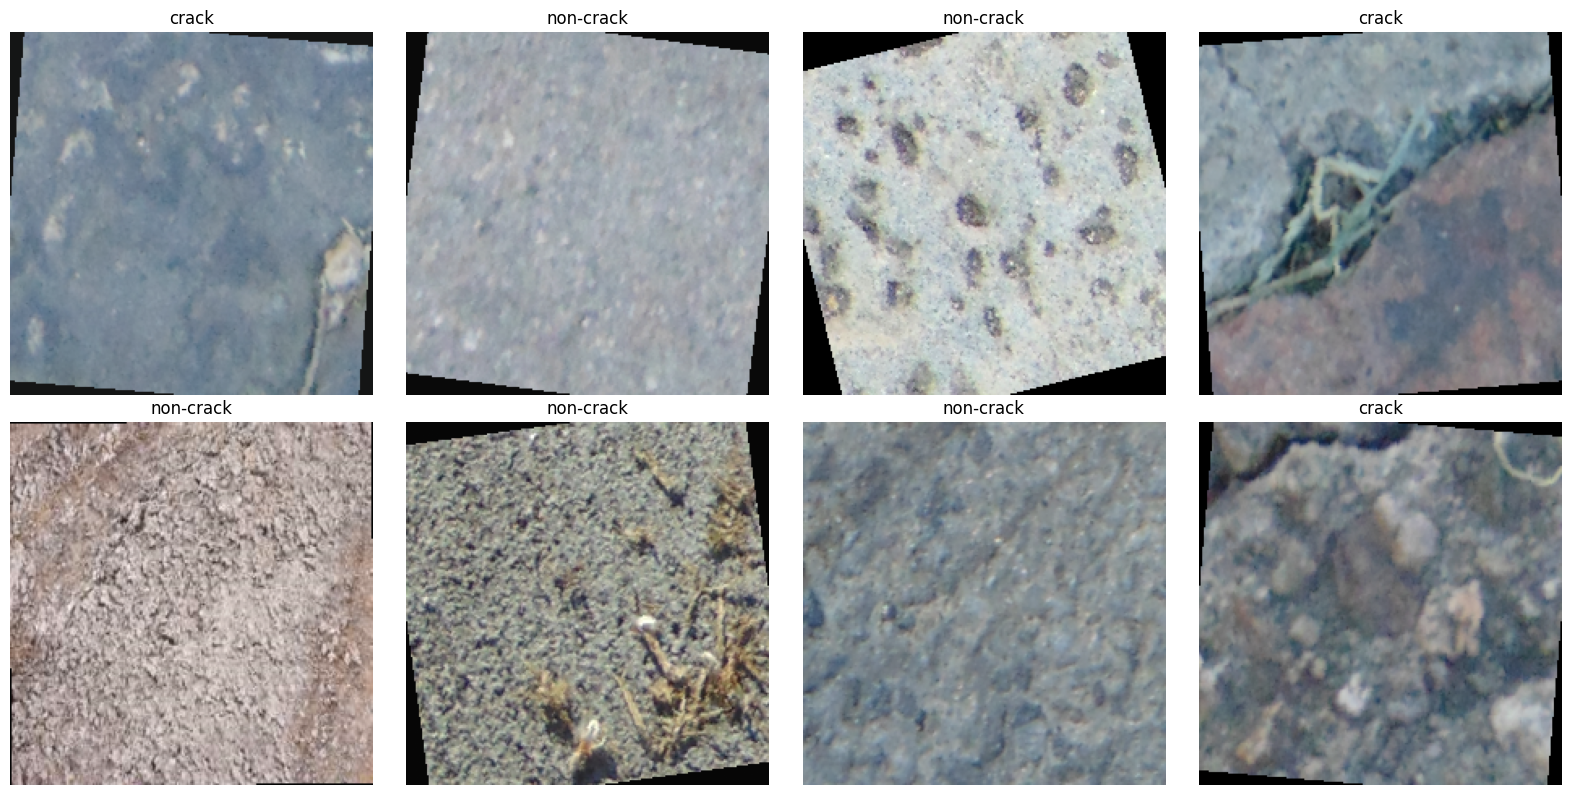

In [22]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(2):
    for j in range(4):
        # Sélectionner une image aléatoire
        idx = torch.randint(0, len(image_datasets["train"]), size = (1,)).cuda()
        image, label = image_datasets["train"][int(idx)]
        
        label = "crack" if int(label) == 0 else "non-crack"
        image = image * torch.tensor(norm_std).view(3, 1, 1) + torch.tensor(norm_mean).view(3, 1, 1)
        image = image.permute(1, 2, 0)
        
        # Afficher l'image (pensez à enlever la dimension canal pour l'affichage)
        axes[i, j].imshow(image.squeeze(), cmap="gray")
        axes[i, j].set_title(f'{label}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Define model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(150528, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.stack.parameters(), lr=1e-3)

    def forward(self, x):
        logits = self.stack(x)
        return logits


class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(in_channels = input_channels, out_channels = 16, kernel_size = 9, padding = 5),
            nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 7, padding = 4),
            nn.MaxPool2d(kernel_size = 5),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 7, padding = 3),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 9, padding = 3),
            nn.MaxPool2d(kernel_size = 7),
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 9, padding = 5),
            nn.MaxPool2d(kernel_size = 7),
            nn.Conv2d(in_channels = 512, out_channels = 128, kernel_size = 5, padding = 3),
            nn.MaxPool2d(kernel_size = 3),
            nn.Conv2d(in_channels = 128, out_channels = 16, kernel_size = 3, padding = 2),
            nn.MaxPool2d(kernel_size = 2),

            nn.Flatten(),

            nn.Linear(in_features = 16, out_features = 2 ** 12),
            nn.ReLU(True),
            nn.Linear(in_features = 2 ** 12, out_features = 2)
        )
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.stack.parameters(), lr=1e-3, weight_decay=1e-4)
        
        # APPLY INITIALIZATION
        self.apply(self._init_weights)
    
    # HE / KAIMING INITIALIZATION
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        logits = self.stack(x)
        return logits


class CustomResNet(nn.Module):
    def __init__(self, num_classes=2, learning_rate=1e-4, freeze_backbone=False):
        super().__init__()
        
        # 1. Load Pre-trained Model
        self.stack = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

        # 2. Training again whole parameters
        if freeze_backbone:
            for param in self.stack.parameters():
                param.requires_grad = False
        
        # 3. Replace the Output Layer
        num_features = self.stack.fc.in_features
        self.stack.fc = nn.Linear(num_features, num_classes)
        
        # 4. Define Loss Function
        self.criterion = nn.CrossEntropyLoss()
        
        # 5. Define Optimizer
        self.optimizer = torch.optim.AdamW(self.stack.parameters(), lr=1e-3, weight_decay=1e-4)
        
    def forward(self, x):
        return self.stack(x)

In [24]:
def save_or_get_model(model, name, op, net = None):
    if op == "save":
        torch.save(model.state_dict(), f"{name}.pth")
    elif op == "get":
        model = net().cuda()
        model.load_state_dict(torch.load(f"{name}.pth", weights_only=True))
        return model
    else:
        print(f"Mode non reconnu")
        return

In [25]:
def train(dataloader, model):
    size = len(dataloader.dataset)
    
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        #y = y.float().unsqueeze(1) 

        # Reset gradients
        model.optimizer.zero_grad()
        
        # Forward
        pred = model(X)

        # Compute loss
        loss = model.criterion(pred, y)

        # Backpropagation
        loss.backward()
        model.optimizer.step()

        loss.item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [26]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()

    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            
            test_loss += model.criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct

In [ ]:
epochs = 10 # Number of training to fine tune
mnn, nnl = NeuralNetwork().cuda(), []
cnn, cnnl = ConvolutionalNeuralNetwork(3).cuda(), []
resnet34, resl = CustomResNet().cuda(), []

for i in range(1): # Number of iterations to commpute mean
    resn = []
    resc = []
    rese = []
    for t in range(epochs):
        #print(f"Model NN;\n-------------------------------")
        #train(dataloaders['val'], mnn)
        #train(dataloaders['train'], mnn)
        #rest = test(dataloaders['test_off'], mnn)
        #resn.append(rest)
        
        #print(f"Model CNN;\n-------------------------------")
        #train(dataloaders['val'], cnn)
        #train(dataloaders['train'], cnn)
        #rest = test(dataloaders['test_off'], cnn)
        #resc.append(rest)
        
        print(f"Model Resnet;\n-------------------------------")
        train(dataloaders['val'], resnet34)
        train(dataloaders['train'], resnet34)
        rest = test(dataloaders['test_off'], resnet34)
        rese.append(rest)

    nnl.append(sum(resn) / (len(resn) + 1e-8))
    cnnl.append(sum(resc) / (len(resc) + 1e-8))
    resl.append(sum(rese) / (len(rese) + 1e-8))

print("Done!")
print(nnl)
print(cnnl)
print(resl)

Loading ResNet34 weights...
Model Resnet;
-------------------------------
loss: 1.120388  [  128/ 5350]
loss: 0.369943  [  128/37442]
loss: 0.317130  [12928/37442]
loss: 0.190241  [25728/37442]
Test Error: 
 Accuracy: 83.6%, Avg loss: 1.503533 

Model Resnet;
-------------------------------
loss: 0.225601  [  128/ 5350]
loss: 0.156392  [  128/37442]
loss: 0.224567  [12928/37442]
loss: 0.173363  [25728/37442]
Test Error: 
 Accuracy: 62.8%, Avg loss: 1.065354 

Model Resnet;
-------------------------------
loss: 0.222552  [  128/ 5350]
loss: 0.120077  [  128/37442]
loss: 0.123860  [12928/37442]
loss: 0.166583  [25728/37442]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.765756 

Model Resnet;
-------------------------------
loss: 0.231456  [  128/ 5350]
loss: 0.219513  [  128/37442]
loss: 0.260911  [12928/37442]
loss: 0.105469  [25728/37442]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.926493 

Model Resnet;
-------------------------------
loss: 0.272611  [  128/ 5350]
loss: 0.140698  [  128/3

In [ ]:
def evaluate_model_metrics(model, dataloader, device, class_names):
    print("\n--- Starting Detailed Evaluation ---")
    model.eval()
    
    # 1. Initialize Ignite Metrics
    precision_metric = Precision(average=False)
    recall_metric = Recall(average=False)
    accuracy_metric = Accuracy()
    
    # Confusion Matrix for 2 classes
    cm_metric = ConfusionMatrix(num_classes=2)
    iou_metric = IoU(cm_metric) 

    # 2. Iterate through test data
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            
            precision_metric.update((outputs, targets))
            recall_metric.update((outputs, targets))
            accuracy_metric.update((outputs, targets))
            cm_metric.update((outputs, targets))

    # 3. Compute Final Results
    pre = precision_metric.compute().cpu()
    rec = recall_metric.compute().cpu()
    acc = accuracy_metric.compute()
    cm = cm_metric.compute().cpu().numpy()
    iou = iou_metric.compute().cpu()

    # 4. Calculate F1 Score
    f1_per_class = (pre * rec * 2) / (pre + rec + 1e-7) 
    f1_mean = f1_per_class.mean().item()
    
    # 5. Print Text Report
    print(f"Global Accuracy: {acc*100:.2f}%")
    print("-" * 30)
    print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'IoU':<10}")
    print("-" * 30)
    
    for i, name in enumerate(class_names):
        print(f"{name:<15} {pre[i]:.4f}     {rec[i]:.4f}     {f1_per_class[i]:.4f}     {iou[i]:.4f}")
        
    print("-" * 30)
    print(f"Macro F1 Score: {f1_mean:.4f}")
    print(f"Mean IoU:       {iou.mean().item():.4f}")

    # 6. Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


evaluate_model_metrics(resnet34, dataloaders['test_off'], device, class_names)